![이미지 설명](./img_sample/in_code_01.png)

In [1]:
from google import genai
from google.genai import types
from PIL import Image, ImageDraw
import io
import base64
import json
import numpy as np
import os

client = genai.Client(
    vertexai=True,
    project="jc-gcp-project",
    location="global",
)

def parse_json(json_output: str):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

def extract_segmentation_masks(image_path: str, output_dir: str = "segmentation_outputs"):
    # Load and resize image
    im = Image.open(image_path)
    im.thumbnail([1024, 1024], Image.Resampling.LANCZOS)

    prompt = """
    Give the segmentation masks for the wooden and glass items.
    Output a JSON list of segmentation masks where each entry contains the 2D
    bounding box in the key "box_2d", the segmentation mask in key "mask", and
    the text label in the key "label". Use descriptive labels.
    """

    config = types.GenerateContentConfig(
        thinking_config=types.ThinkingConfig(thinking_budget=0) # set thinking_budget to 0 for better results in object detection
    )

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[prompt, im], # Pillow images can be directly passed as inputs (which will be converted by the SDK)
        config=config
    )

    # Parse JSON response
    items = json.loads(parse_json(response.text))

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Process each mask
    for i, item in enumerate(items):
        # Get bounding box coordinates
        box = item["box_2d"]
        y0 = int(box[0] / 1000 * im.size[1])
        x0 = int(box[1] / 1000 * im.size[0])
        y1 = int(box[2] / 1000 * im.size[1])
        x1 = int(box[3] / 1000 * im.size[0])

        # Skip invalid boxes
        if y0 >= y1 or x0 >= x1:
            continue

        # Process mask
        png_str = item["mask"]
        if not png_str.startswith("data:image/png;base64,"):
            continue

        # Remove prefix
        png_str = png_str.removeprefix("data:image/png;base64,")
        mask_data = base64.b64decode(png_str)
        mask = Image.open(io.BytesIO(mask_data))

        # Resize mask to match bounding box
        mask = mask.resize((x1 - x0, y1 - y0), Image.Resampling.BILINEAR)

        # Convert mask to numpy array for processing
        mask_array = np.array(mask)

        # Create overlay for this mask
        overlay = Image.new('RGBA', im.size, (0, 0, 0, 0))
        overlay_draw = ImageDraw.Draw(overlay)

        # Create overlay for the mask
        color = (255, 255, 255, 200)
        for y in range(y0, y1):
            for x in range(x0, x1):
                if mask_array[y - y0, x - x0] > 128:  # Threshold for mask
                    overlay_draw.point((x, y), fill=color)

        # Save individual mask and its overlay
        mask_filename = f"{item['label']}__mask.png"
        overlay_filename = f"{item['label']}__overlay.png"

        mask.save(os.path.join(output_dir, mask_filename))

        # Create and save overlay
        composite = Image.alpha_composite(im.convert('RGBA'), overlay)
        composite.save(os.path.join(output_dir, overlay_filename))
        print(f"Saved mask and overlay for {item['label']} to ")


extract_segmentation_masks("./img_sample/other_sample_03.png")

JSONDecodeError: Extra data: line 32 column 1 (char 6676)

In [2]:
image_path = "./img_sample/other_sample_03.png"

In [3]:
im = Image.open(image_path)
im.thumbnail([1024, 1024], Image.Resampling.LANCZOS)

prompt = """
Give the segmentation masks for the wooden and glass items.
Output a JSON list of segmentation masks where each entry contains the 2D
bounding box in the key "box_2d", the segmentation mask in key "mask", and
the text label in the key "label". Use descriptive labels.
"""

config = types.GenerateContentConfig(
    thinking_config=types.ThinkingConfig(thinking_budget=0) # set thinking_budget to 0 for better results in object detection
)

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=[prompt, im], # Pillow images can be directly passed as inputs (which will be converted by the SDK)
    config=config
)

In [4]:
response

GenerateContentResponse(
  automatic_function_calling_history=[],
  candidates=[
    Candidate(
      avg_logprobs=-0.33219306228052864,
      content=Content(
        parts=[
          Part(
            text="""```json
[
  {"box_2d": [599, 497, 665, 768], "mask": "<start_of_mask><seg_111><seg_71><seg_91><seg_116><seg_19><seg_68><seg_50><seg_94><seg_62><seg_44><seg_51><seg_78><seg_5><seg_66><seg_88><seg_115>", "label": "wooden tray"},
  {"box_2d": [478, 584, 626, 655], "mask": "<start_of_mask><seg_125><seg_45><seg_6><seg_71><seg_64><seg_26><seg_34><seg_61><seg_11><seg_80><seg_27><seg_15><seg_73><seg_15><seg_50><seg_75>", "label": "glass vase"},
  {"box_2d": [504, 128, 565, 172], "mask": "<start_of_mask><seg_107><seg_115><seg_39><seg_29><seg_58><seg_41><seg_116><seg_52><seg_62><seg_27><seg_94><seg_15><seg_67><seg_46><seg_65><seg_3>", "label": "wooden spoon holder"},
  {"box_2d": [488, 631, 608, 701], "mask": "<start_of_mask><seg_11><seg_65><seg_53><seg_55><seg_69><seg_35><seg_44><seg_15

## Getting Started

In [1]:
from google import genai
from google.genai import types
import base64
# import google.generativeai as genai
from PIL import Image
import io
import os
import requests
from io import BytesIO
import json
from PIL import Image, ImageDraw, ImageFont
from google.cloud import storage
from datetime import datetime
import random
from rembg import remove
import numpy as np
import cv2
import random

## Helper functions

In [2]:
# @title Parsing JSON output
def parse_json(json_output: str):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [3]:
def show_original_image(image_path: str):
    """
    Displays the original image directly in the Jupyter/IPython notebook.
    """
    try:
        im = Image.open(image_path)
        print(f"Displaying original image: {os.path.basename(image_path)}")
        display(im)
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
    except Exception as e:
        print(f"An error occurred while displaying the image: {e}")

In [4]:
def extract_segmentation_masks_04(image_path: str, output_dir: str = "segmentation_outputs"):
    """
    (최종 간소화 버전) 원본 이미지를 직접 분석하여 객체를 감지하고 바운딩 박스를 그립니다.
    """
    try:
        # 1. 원본 이미지를 로드합니다. (리사이즈 없음)
        original_image = Image.open(image_path)
        
        # 원본 이미지의 크기를 바로 가져옵니다.
        img_width, img_height = original_image.size
        print(f"--- 🖼️ 원본 이미지 크기: {img_width}x{img_height} ---")

    except FileNotFoundError:
        print(f"❌ 오류: '{image_path}' 경로에서 이미지를 찾을 수 없습니다.")
        return
    except Exception as e:
        print(f"❌ 오류: 이미지를 준비하는 중 문제가 발생했습니다: {e}")
        return

    # 2. 프롬프트를 설정합니다. (모델에게 정규화된 좌표를 요청)
    client = genai.Client(vertexai=True, project="jc-gcp-project", location="global")
    prompt = """
    Analyze the image and identify up to 10 distinct objects that are clearly visible and in sharp focus. 
    Ignore items that are blurry, in the background, or mostly obscured by other objects.
    Return Precise object location information.
    Output a JSON list of objects. For each object, provide:
    1. "box_2d": A 2D bounding box [y_min, x_min, y_max, x_max]. The coordinates must be NORMALIZED from 0.0 to 1.0.
    2. "label": A descriptive text label for the item.
    
    Example format:
    ```json
    [
      {
        "box_2d": [0.1, 0.15, 0.25, 0.30],
        "label": "example wooden item"
      }
    ]
    
    """
    
    # 3. 원본 이미지를 그대로 모델에 전달하여 분석합니다.
    print("🤖 모델을 호출하여 원본 이미지 분석을 시작합니다...")
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[prompt, original_image],
        # thinking_budget을 0으로 설정하면 객체 감지 성능이 향상될 수 있습니다.
        config=types.GenerateContentConfig(thinking_config=types.ThinkingConfig(thinking_budget=0))
    )

    try:
        # 모델 응답에서 JSON 부분만 깔끔하게 추출합니다.
        cleaned_json_text = response.text.strip().replace("```json", "").replace("```", "")
        items = json.loads(cleaned_json_text)
        if not items:
            print("⚠️ 모델이 이미지에서 객체를 찾지 못했습니다.")
            return
        # print(items)
    except (json.JSONDecodeError, IndexError, AttributeError) as e:
        print(f"❌ 오류: 모델의 응답을 파싱하는 데 실패했습니다. {e}")
        print(f"📄 모델 원본 응답: {response.text}")
        return

    # 4. 원본 이미지 위에 바로 그릴 준비를 합니다.
    final_image = original_image.convert("RGBA")
    draw = ImageDraw.Draw(final_image)
    print(f"✅ 총 {len(items)}개의 객체를 감지했습니다. 이미지에 그리는 중...")

    for item in items:
        label = item.get("label", "unknown")
        box = item.get("box_2d")

        if not box or len(box) != 4:
            continue

        # --- 지능형 스케일링 로직 ---
        # box 안의 값 중 하나라도 1.0을 초과하면 1000 기준 좌표로, 아니면 정규화된 좌표로 판단합니다.
        if any(coord > 1.0 for coord in box):
            # [363, 508, ...] 같은 1000 기준 좌표일 경우
            scaled_box = [
                box[1] / 1000 * img_width,  # x_min
                box[0] / 1000 * img_height, # y_min
                box[3] / 1000 * img_width,  # x_max
                box[2] / 1000 * img_height  # y_max
            ]
        else:
            # [0.384, 0.493, ...] 같은 정규화된 좌표일 경우
            scaled_box = [
                box[1] * img_width,  # x_min
                box[0] * img_height, # y_min
                box[3] * img_width,  # x_max
                box[2] * img_height  # y_max
            ]
        # --------------------------

        # 안전장치: 그리기 전 좌표 유효성 검사
        if scaled_box[2] < scaled_box[0] or scaled_box[3] < scaled_box[1]:
            print(f"  - ⚠️ [{label}] 객체의 좌표값이 잘못되어 건너뜁니다: {scaled_box}")
            continue

        # 그리기 로직 (기존과 동일)
        color = (random.randint(100, 255), random.randint(100, 255), random.randint(100, 255))
        draw.rectangle(scaled_box, outline=color, width=4)
        try:
            font = ImageFont.truetype("arial.ttf", 20)
        except IOError:
            font = ImageFont.load_default()

        text_position = (scaled_box[0] + 5, scaled_box[1] + 5)
        text_bbox = draw.textbbox(text_position, label, font=font)
        draw.rectangle(text_bbox, fill=color)
        draw.text(text_position, label, fill=(255, 255, 255), font=font)

    # 6. 최종 이미지 저장 및 표시
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    filename = f"{base_filename}_boxed_{timestamp}.png"
    full_output_path = os.path.join(output_dir, filename)
    
    final_image.save(full_output_path)
    display(final_image)
    print(f"✅ 성공! 결과가 '{full_output_path}' 파일로 저장되었습니다.")

--- 🖼️ 원본 이미지 크기: 1176x650 ---
🤖 모델을 호출하여 원본 이미지 분석을 시작합니다...
✅ 총 10개의 객체를 감지했습니다. 이미지에 그리는 중...
  - ⚠️ [Pinterest logo on court] 객체의 좌표값이 잘못되어 건너뜁니다: [1174.824, 159.9, 1045.464, 305.5]


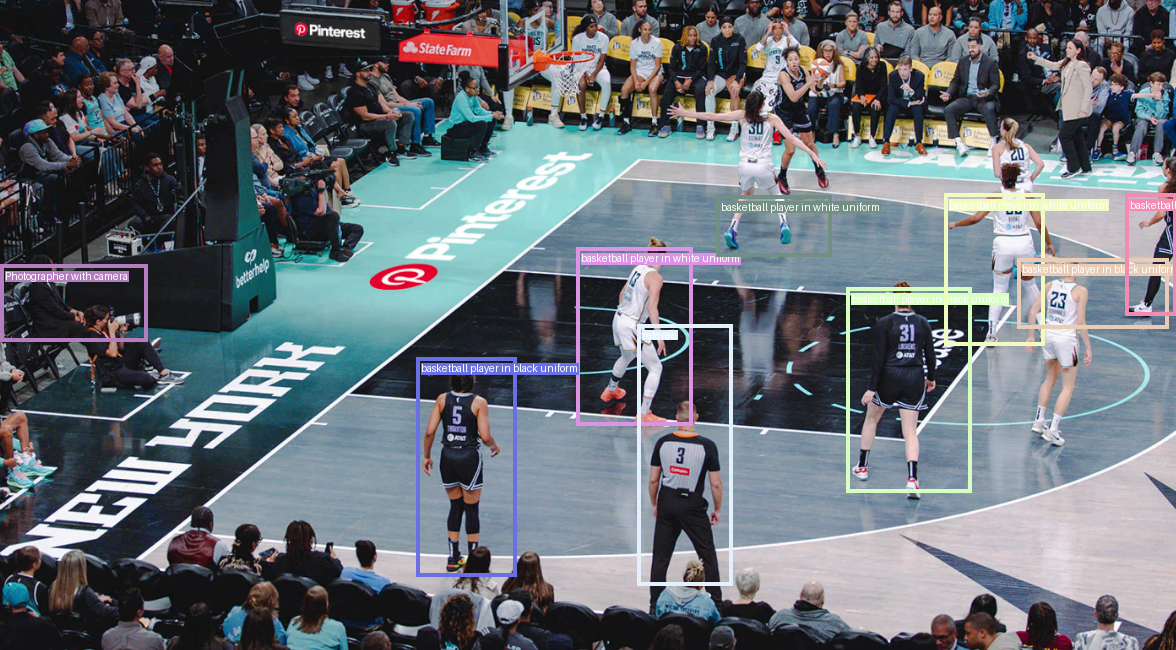

✅ 성공! 결과가 'segmentation_outputs/other_sample_02_boxed_20250828_153648.png' 파일로 저장되었습니다.


In [5]:
extract_segmentation_masks_04("img_sample/other_sample_02.png", "segmentation_outputs")

## Segmentation

In [6]:
def create_panoptic_segmentation_revised(image_path: str, user_prompt: str):
    """
    Gemini와 rembg를 연동하여 이미지의 파놉틱 세그멘테이션을 수행합니다.
    """
    client = genai.Client(
        vertexai=True,
        project="jc-gcp-project",
        location="global",
    )
    
    # --- 수정된 부분 1: 이미지를 한번만 로드하고 리사이즈 ---
    try:
        # 이 image_to_process 객체를 분석, 그리기, 자르기 등 모든 작업에 사용합니다.
        image_to_process = Image.open(image_path)
        image_to_process.thumbnail([1024, 1024], Image.Resampling.LANCZOS)
    except Exception as e:
        print(f"이미지 로드 오류: {e}")
        return

    prompt = f"""
    Analyze the image based on the user's request: "{user_prompt}".
    Identify all distinct objects relevant to the request.
    For each object found, provide its 2D bounding box.
    Output a JSON list. Each object should have:
    1. "label": The object's name.
    2. "box_2d": The bounding box [ymin, xmin, ymax, xmax] normalized to 1000.
    """

    panoptic_schema = { "type": "OBJECT", "properties": { "locations": { "type": "ARRAY", "description": "A list of all distinct objects found in the image.", "items": { "type": "OBJECT", "properties": { "label": { "type": "STRING", "description": "The name of the object." }, "box_2d": { "type": "ARRAY", "description": "The bounding box [ymin, xmin, ymax, xmax], normalized to 1000.", "items": { "type": "NUMBER" } } }, "required": ["label", "box_2d"] } } }, "required": ["locations"] }
    config = types.GenerateContentConfig( thinking_config=types.ThinkingConfig(thinking_budget=0), response_mime_type = "application/json", response_schema=panoptic_schema, )
    
    response = client.models.generate_content(
        model="gemini-2.5-flash", # 복잡한 작업을 위해 Pro 모델 권장
        contents=[prompt, image_to_process], # 리사이즈된 이미지를 전달
        config=config
    )
    
    # (JSON 파싱 부분은 그대로 유지)
    text_response = response.text
    parsed_data = json.loads(text_response)
    locations = parsed_data['locations'] 

    print(f"Gemini가 {len(locations)}개의 객체를 찾았습니다: {[loc['label'] for loc in locations]}")
    print("\n---  각 객체별로 정교한 마스크 생성 및 종합 중 ---")

    # --- 수정된 부분 2: 원본 이미지를 다시 로드하는 대신, 리사이즈된 이미지를 RGBA로 변환하여 사용 ---
    image_rgba = image_to_process.convert("RGBA")
        
    final_mask_overlay = Image.new("RGBA", image_rgba.size, (0, 0, 0, 0))
    final_image_with_boxes = image_rgba.copy()
    draw_boxes = ImageDraw.Draw(final_image_with_boxes)

    LABEL_TEXT_COLOR = "white"
    
    for loc in locations:
        label = loc.get('label')
        box = loc.get('box_2d')
        if not label or not box: continue

        object_color = (random.randint(80, 220), random.randint(80, 220), random.randint(80, 220))
        print(f"  - '{label}' 처리 중 (색상: {object_color})...")
        
        width, height = image_rgba.size
        ymin, xmin, ymax, xmax = box
        crop_box = (
            int(xmin / 1000 * width), int(ymin / 1000 * height),
            int(xmax / 1000 * width), int(ymax / 1000 * height)
        )
        if crop_box[0] >= crop_box[2] or crop_box[1] >= crop_box[3]: continue
        
        # rembg 처리를 위해 image_rgba (리사이즈된 이미지)에서 자릅니다.
        cropped_image = image_rgba.crop(crop_box)
        mask_image = remove(cropped_image, post_process_mask=True)

        mask_color_with_alpha = object_color + (192,)
        color_layer = Image.new("RGBA", mask_image.size, mask_color_with_alpha)
        
        colored_mask = Image.new("RGBA", mask_image.size)
        colored_mask.paste(color_layer, (0, 0), mask_image)
        final_mask_overlay.paste(colored_mask, crop_box, colored_mask)
        
        draw_boxes.rectangle(crop_box, outline=object_color, width=5)
        
        try: font = ImageFont.truetype("arialbd.ttf", 10)
        except IOError: font = ImageFont.load_default(size=10)
        
        text_position = (crop_box[0] + 5, crop_box[1] + 5)
        text_bbox = draw_boxes.textbbox(text_position, label, font=font)
        label_bg_box = (text_bbox[0] - 5, text_bbox[1] - 3, text_bbox[2] + 5, text_bbox[3] + 3)

        draw_boxes.rectangle(label_bg_box, fill=object_color)
        draw_boxes.text(text_position, label, fill=LABEL_TEXT_COLOR, font=font)

    print("\n--- 최종 결과물 생성 및 합성 중 ---")
    final_result_with_mask_only = Image.alpha_composite(image_rgba, final_mask_overlay)
    final_image_with_all = final_image_with_boxes
    final_image_with_all.paste(final_mask_overlay, (0, 0), final_mask_overlay)
    
    # (파일 저장 및 display 부분은 그대로 유지)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    OUTPUT_DIR = "output_images"
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    panoptic_path = os.path.join(OUTPUT_DIR, f"panoptic_mask_only_{timestamp}.png")
    final_result_with_mask_only.save(panoptic_path)
    
    box_and_mask_path = os.path.join(OUTPUT_DIR, f"panoptic_full_{timestamp}.jpg")
    final_image_with_all.convert("RGB").save(box_and_mask_path)

    print(f"✅ 세그멘테이션 결과가 '{panoptic_path}' 와 '{box_and_mask_path}'에 저장되었습니다.")
    display(final_image_with_all)
    
    return final_result_with_mask_only, final_image_with_all

Gemini가 2개의 객체를 찾았습니다: ['human', 'animal']

---  각 객체별로 정교한 마스크 생성 및 종합 중 ---
  - 'human' 처리 중 (색상: (188, 122, 113))...
  - 'animal' 처리 중 (색상: (129, 130, 184))...

--- 최종 결과물 생성 및 합성 중 ---
✅ 세그멘테이션 결과가 'output_images/panoptic_mask_only_20250824_084608.png' 와 'output_images/panoptic_full_20250824_084608.jpg'에 저장되었습니다.


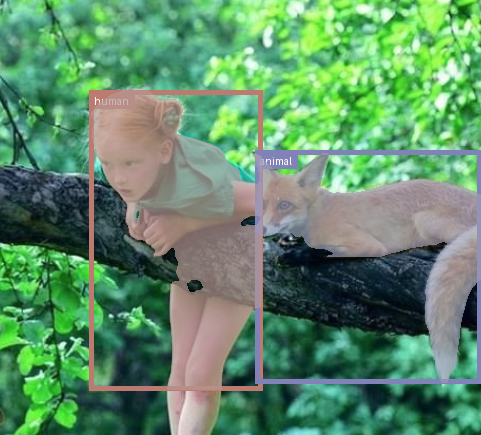

(<PIL.Image.Image image mode=RGBA size=481x435>,
 <PIL.Image.Image image mode=RGBA size=481x435>)

In [7]:
# 예시 1: 이미지에 있는 모든 것을 찾아달라고 요청
create_panoptic_segmentation_revised(
    image_path="img_sample/other_sample_05.png", 
    user_prompt="Find all human and animal in this image"
)

Gemini가 10개의 객체를 찾았습니다: ['basketball court', 'player', 'player', 'player', 'player', 'player', 'player', 'player', 'referee', 'spectator']

---  각 객체별로 정교한 마스크 생성 및 종합 중 ---
  - 'basketball court' 처리 중 (색상: (175, 84, 113))...
  - 'player' 처리 중 (색상: (170, 214, 137))...
  - 'player' 처리 중 (색상: (124, 182, 149))...
  - 'player' 처리 중 (색상: (161, 207, 157))...
  - 'player' 처리 중 (색상: (131, 204, 216))...
  - 'player' 처리 중 (색상: (127, 134, 110))...
  - 'player' 처리 중 (색상: (122, 165, 115))...
  - 'player' 처리 중 (색상: (84, 208, 98))...
  - 'referee' 처리 중 (색상: (201, 100, 215))...
  - 'spectator' 처리 중 (색상: (193, 109, 171))...

--- 최종 결과물 생성 및 합성 중 ---
✅ 세그멘테이션 결과가 'output_images/panoptic_mask_only_20250824_084635.png' 와 'output_images/panoptic_full_20250824_084635.jpg'에 저장되었습니다.


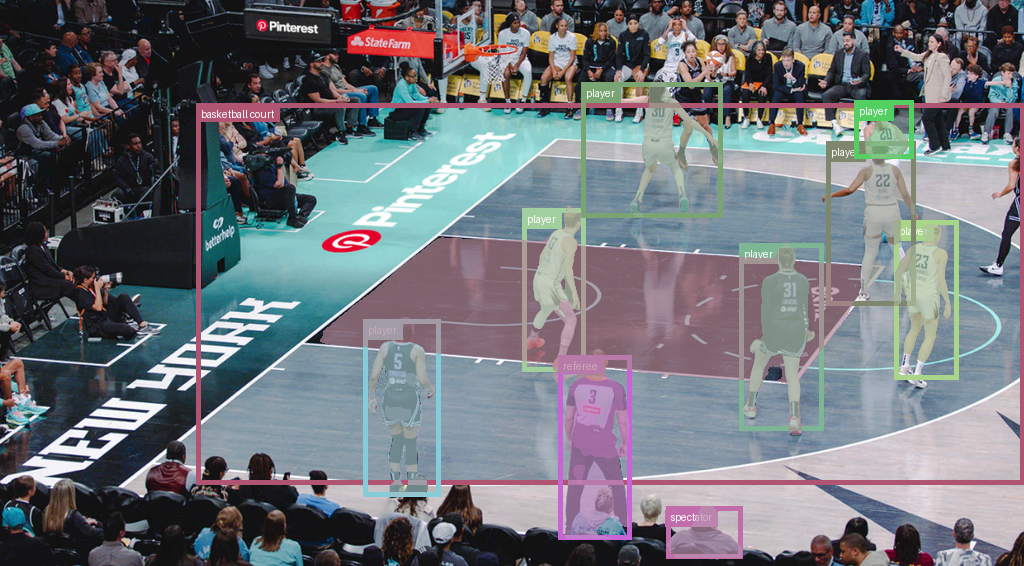

(<PIL.Image.Image image mode=RGBA size=1024x566>,
 <PIL.Image.Image image mode=RGBA size=1024x566>)

In [8]:
# 예시 1: 이미지에 있는 모든 것을 찾아달라고 요청
create_panoptic_segmentation_revised(
    image_path="img_sample/other_sample_02.png", 
    user_prompt="Find all things you can see in this image limit 10"
)